In [ ]:
# Import Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
# Download MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Prepare data loaders with batch size 128
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Epoch [1/5], Train Loss: 0.8558, Val Loss: 0.2860, Train Acc: 91.33%, Val Acc: 91.33%
Epoch [2/5], Train Loss: 0.2261, Val Loss: 0.1700, Train Acc: 94.96%, Val Acc: 94.96%
Epoch [3/5], Train Loss: 0.1425, Val Loss: 0.1206, Train Acc: 96.45%, Val Acc: 96.45%
Epoch [4/5], Train Loss: 0.1069, Val Loss: 0.0997, Train Acc: 97.03%, Val Acc: 97.03%
Epoch [5/5], Train Loss: 0.0881, Val Loss: 0.0894, Train Acc: 97.21%, Val Acc: 97.21%


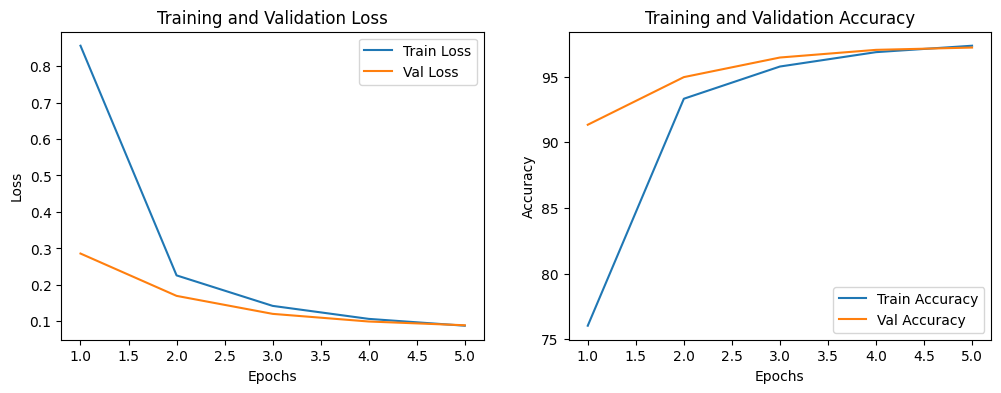

Model saved as SmallCNN.pt


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)  # Flattening the tensor Can use self.flatten = nn.Flatten()
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# class SmallCNN(nn.Module):
#   def __init__(self):
#     super(SmallCNN, self).__init__()
#     self.features = nn.Sequential(
#         nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#         nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#     )
#     self.fc = nn.Sequential(
#         nn.Linear(32 * 7 * 7, 128),
#         nn.Linear(128, 10)
#     )

#   def forward(self, x):
#     x = self.features(x)
#     x = x.view(-1, 32 * 7 * 7)
#     x = self.fc(x)
#     return x


# Prepare data loaders
best_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Initialize model, loss function, and optimizer
model = SmallCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03)

# Training the model
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100. * correct / total)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100. * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Train Acc: {100. * correct / total:.2f}%, "
          f"Val Acc: {100. * correct / total:.2f}%")

# Plotting loss and accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), 'SmallCNN.pt')
print("Model saved as SmallCNN.pt")

In [ ]:
model.eval()
test_loss, correct, total = 0, 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {100. * correct / total:.2f}%, ")

Test Loss: 0.0769, Test Accuracy: 97.69%, 
